# Deutsch-Jozsa
The Deutsch-Jozsa algorithim is one of the first examples of how a quantum algorithm can outperform classical computing on a specific task.

## What is Deutsch-Jozsa
Given a function which takes an *n-bit string* and outputs either 0 or 1:
$f:\{0,1\}^n\to\{0,1\}$
You are promised that f is one of two types:
* **Constant**: returns the same value for all inputs.
* **Balanced**: returns 0 for half of the inputs and 1 for the other half.

### Classically difficult
In the worst case you'd have to check $2^{n-1}+1$ inputs to be sure it was balanced or constant. You might keep getting the same output until you test one more input to see if it changes. So, logically, you have to test at least half of all n-length inputs.

### Quantum Advantage
The Deutsch-Jozsa algorithm can determine the answer with just one evaluation of $f$ using superposition.

Instead of testing one at a time, you evaluate f(x) for all possible x simultaneously!

The single oracle invocation acts on all inputs at once. Applying it on the input register in superposition applies $f(x)$ for every x.

After the oracle, more Hadamards make amplitudes interfere constructively or destructively depending on the structure of $f$.

The speedup is about query complexity, not necessarily total runtime.

## Oracle Structures (1, 2, and 3 Qubit Inputs)

The purpose of the oracle is to apply a reversible operation to the ancilla qubit that encodes the result of $f(x)$. The oracle is a "black box" which takes in the n-qubits of input and the ancilla, performs operations of the function $f(x)$ and ensures the overall operation is unitary and reversible.

### What an oracle cannot do
The oracle cannot entangle the input(s) with the output of $f(x)$ or the ancilla. Entangling the input qubits would disrupt their interference pattern needed to determine whether $f(x)$ is constant or balanced.

### How the oracle works
A common way to implement an oracle is using multi-CNOTs with the ancilla as the target. Normally, a CNOT would entangle the control and target qubits. However, in Deutsch-Jozsa, all qubits are put into superposition using Hadamards. Applying a CNOT then results in nothing or a phase flip on every qubit. The input qubits remain separable, and the phase of each input state encodes $f(x)$: a negative phase means $f(x)=1$, and a positive phase corresponds to $f(x)=0$.

### Scaling to more input qubits
For more than one input qubit, the oracle still encodes $f(x)$ into a single ancilla:
- **Two Qubits**: If $f(x_1, x_2) = x_1\otimes{x_2}$, the oracle applies CNOTs from both $x_1$ and $x_2$ to the ancilla.
- **Three Qubits**: If $f(x_1, x_2, x_3) = x_1x_2\otimes{x_3}$, the oracle uses a Toffoli on $x_1$ and $x_2$ followed by a CNOT from $x_3$ to the ancilla.

In general, the oracle's internal structure is unknown. In practice, we do not know which input qubits affect the output. The oracle represents the unknown $f(x)$, which may be constant or balanced.

### Why we can represent all inputs at once
We start with an n-qubit input initialized to $\ket{0...0}$. After applying Hadamards, the register enters a superposition of all possible input strings. For 3 qubits, it represents all 8 possible 3-bit sequences simultaneously:
$$000, 001, 010, 011, 100, 101, 110, 111$$
The oracle applies $f(x)$ to each of these inputs in parallel via phase kickback. After the oracle, we apply a Hadamard to all the input qubits again to cause **interference** among all the possible inputs:
- If $f(x)$ is constant, all amplitudes interfere constructively and measuring $\ket{0...0}$ is guaranteed.
- If $f(x)$ is balanced, the amplitude at $\ket{0...0}$ cancels out, and the probability of measuring *any other state* is non-zero.

Lastly, you measure all the input qubits. If the result is all $0...0$ (the input state), the function is constant. If the result is anything else, the function is balanced.

## High-Level Implementation
* Prepare $n$ qubits in state $\ket{0}$ and one auxiliary qubit in $\ket{1}$: $$\ket{0}^{\otimes{n}}\ket{1}$$
* Apply Hadamard gates on all qubits to create superpositions of all possible inputs.
* Apply the oracle $U_f$ on the input qubits.
* Apply Hadamard gates on the first *n* qubits to transform the phase information $U_f$ added into measurable amplitudes.
* Measure the input qubits. If $f(x)$ is constant, the result is $0...0$. If $f(x)$ is balanced the result is anything else.

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from math import log2
import matplotlib.pyplot as plt

In [40]:
def deutsch_jozsa_circuit(oracle, n):
	# create a circuit with 1 register containing n+1 qubits.
	circuit = QuantumCircuit(n+1, n)
	# set ancilla to the 1 state
	circuit.x(n)
	# apply H to all qubits
	circuit.h(range(n+1))
	circuit.barrier()
	# append oracle
	circuit.compose(oracle, inplace=True)
	circuit.barrier()
	# apply H to first n qubits
	circuit.h(range(n))
	# measure input qubits
	circuit.measure(range(n), range(n))
	return circuit

In [3]:
# Oracles for n = 1
def oracle_constant_zero_n1():
    # a circuit that does nothing
    # f(x) = 1;
    return QuantumCircuit(2)

def oracle_constant_one_n1():
    # f(x) = 0;
    qc = QuantumCircuit(2)
    qc.x(1) # flip ancilla (input doesn't matter).
    return qc

def oracle_balanced_identity_n1():
    # f(x) = x
    qc = QuantumCircuit(2)
    # As mentioned before, CNOT the output with ancilla to effectively encode
    # the result into the phase of the input qubit.
    qc.cx(0, 1)
    return qc

# Assign labels to each test function
oracles_n1 = {
    'const0': oracle_constant_zero_n1(),
    'const1': oracle_constant_one_n1(),
    'balanced_x': oracle_balanced_identity_n1()
}

In [4]:
# Oracles for n = 2
def oracle_constant_zero_n2():
    # a circuit that does nothing.
    # f(x) = 1
    return QuantumCircuit(3)

def oracle_constant_one_n2():
    # f(x) = 0
    qc = QuantumCircuit(3)
    qc.x(2)
    return qc

def oracle_parity_n2():
    # f(x0,x1) = x0 XOR x1
    # this means CNOT x0 and x1 with ancilla.
    qc = QuantumCircuit(3)
    qc.cx(0,2)
    qc.cx(1,2)
    return qc

def oracle_projection_q0_n2():
    # f(x) = x0
    # this means CNOT x0 with ancilla.
    qc = QuantumCircuit(3)
    qc.cx(0,2)
    return qc

# Assign labels to each test function
oracles_n2 = {
    'const0': oracle_constant_zero_n2(),
    'const1': oracle_constant_one_n2(),
    'parity': oracle_parity_n2(),
    'proj_q0': oracle_projection_q0_n2()
}

In [5]:
# Oracles for n = 3
def oracle_constant_zero_n3():
    # a circuit that does nothing
    # f(x) = 1
    return QuantumCircuit(4)

def oracle_constant_one_n3():
    # f(x) = 0
    qc = QuantumCircuit(4)
    qc.x(3)
    return qc

def oracle_parity_n3():
    # f(x0,x1,x2) = x0 XOR x1 XOR x2
    # this means apply CNOT with every input qubit and the ancilla.
    qc = QuantumCircuit(4)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    return qc

def oracle_proj_q1_n3():
    # f(x) = x1
    qc = QuantumCircuit(4)
    qc.cx(1,3)
    return qc

# Assign labels to each test function
oracles_n3 = {
    'const0': oracle_constant_zero_n3(),
    'const1': oracle_constant_one_n3(),
    'parity3': oracle_parity_n3(),
    'proj_q1': oracle_proj_q1_n3()
}

Results for n=1 const0:
{'0': 1024}


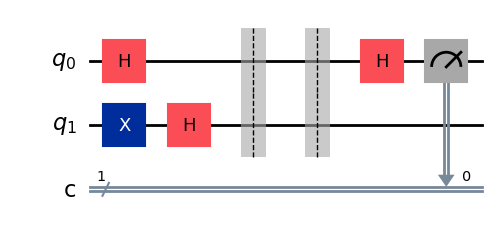

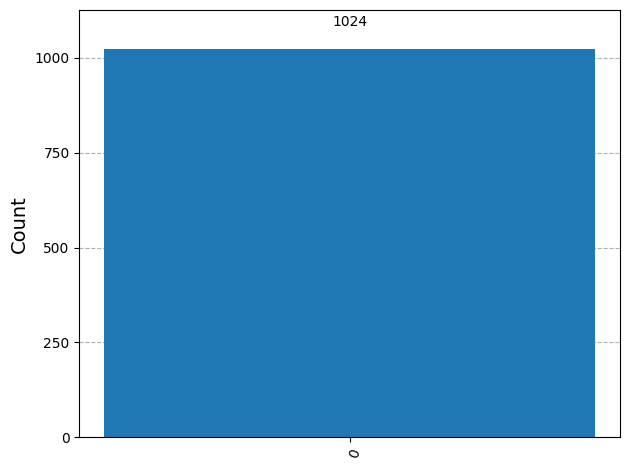

Results for n=1 const1:
{'0': 1024}


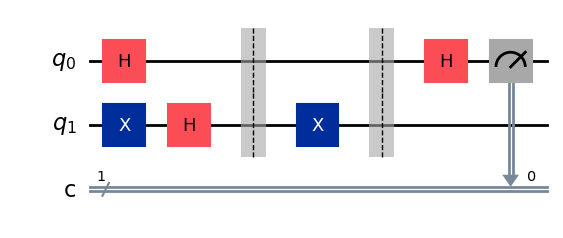

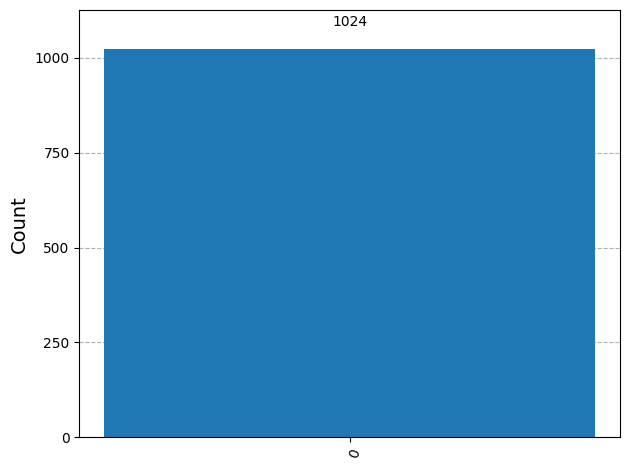

Results for n=1 balanced_x:
{'1': 1024}


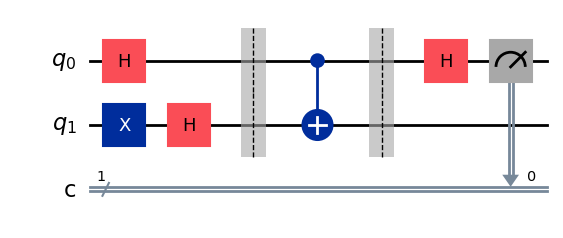

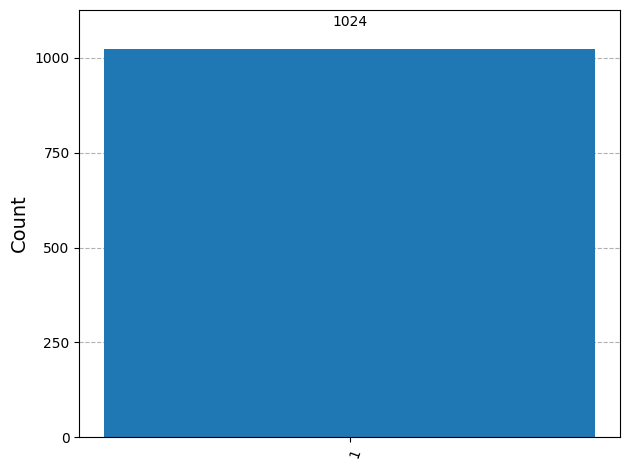

Results for n=2 const0:
{'00': 1024}


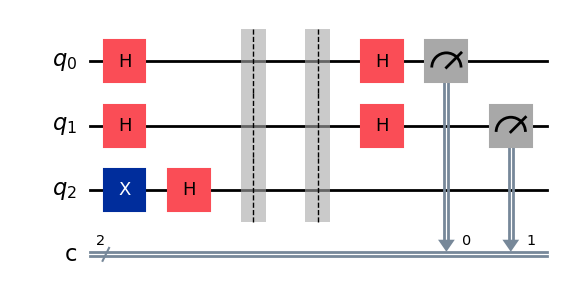

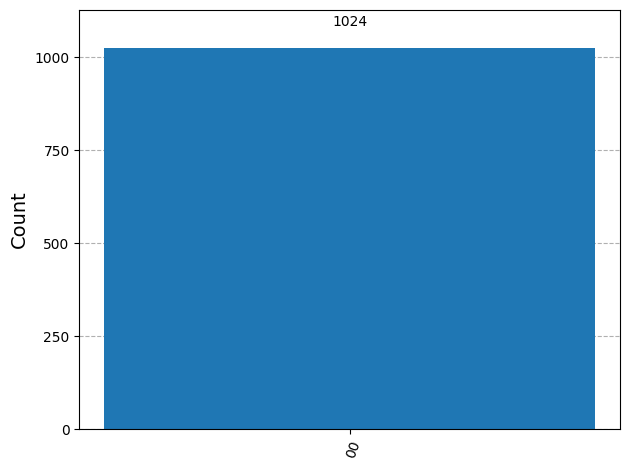

Results for n=2 const1:
{'00': 1024}


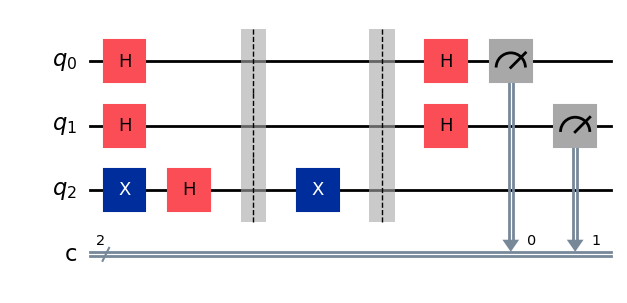

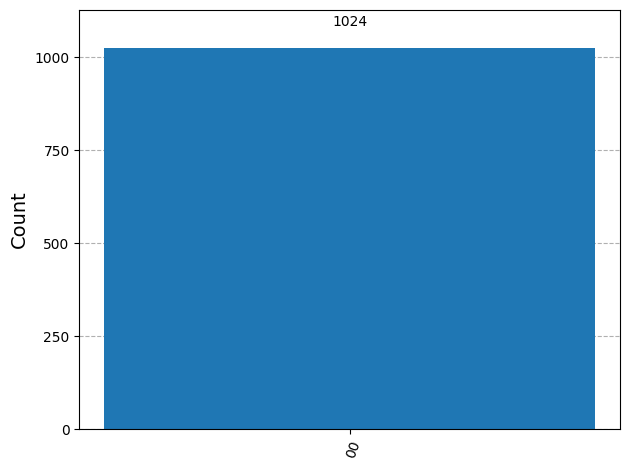

Results for n=2 parity:
{'11': 1024}


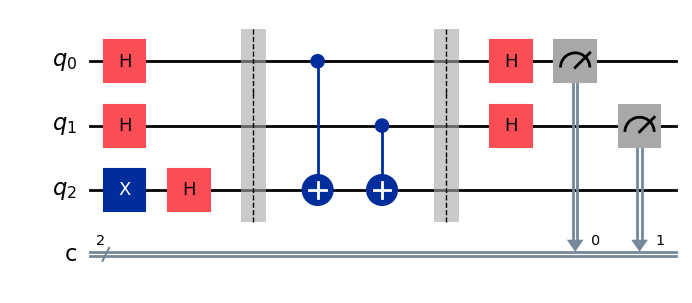

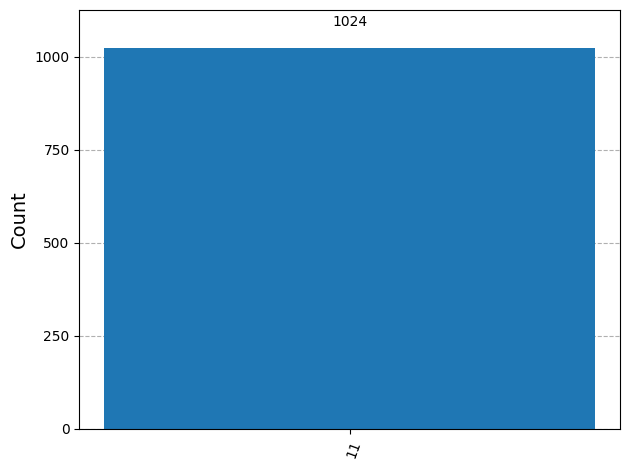

Results for n=2 proj_q0:
{'01': 1024}


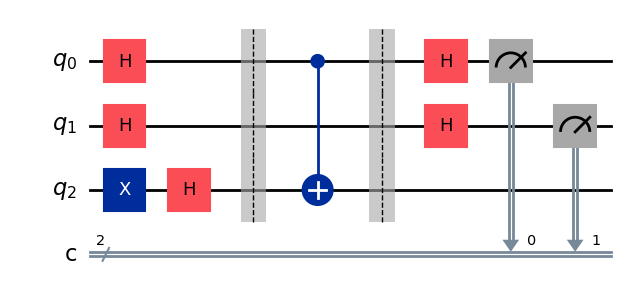

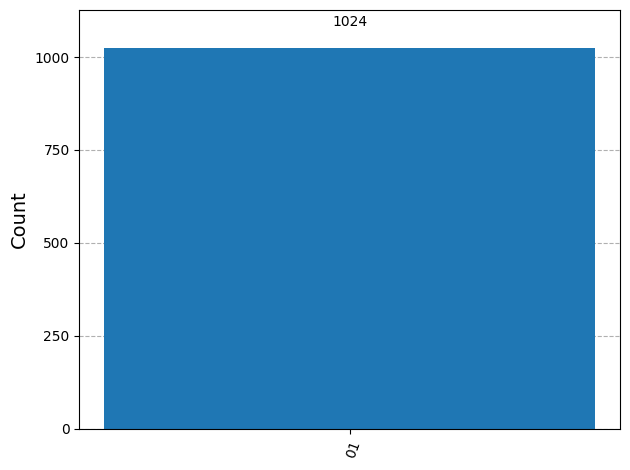

Results for n=3 const0:
{'000': 1024}


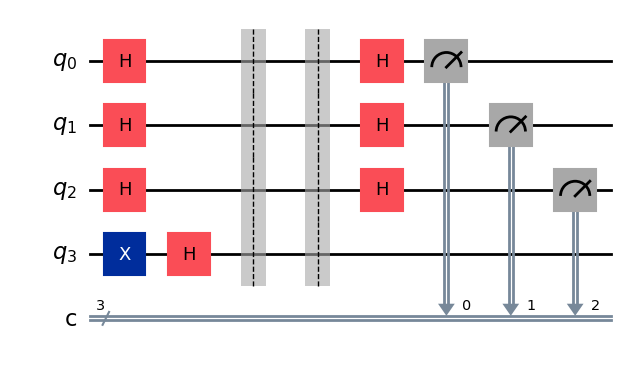

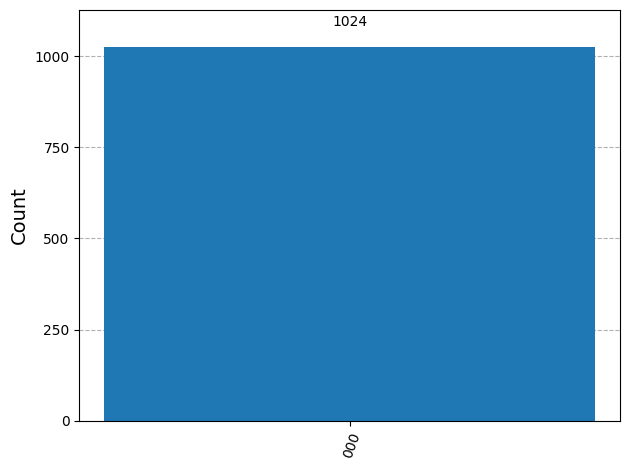

Results for n=3 const1:
{'000': 1024}


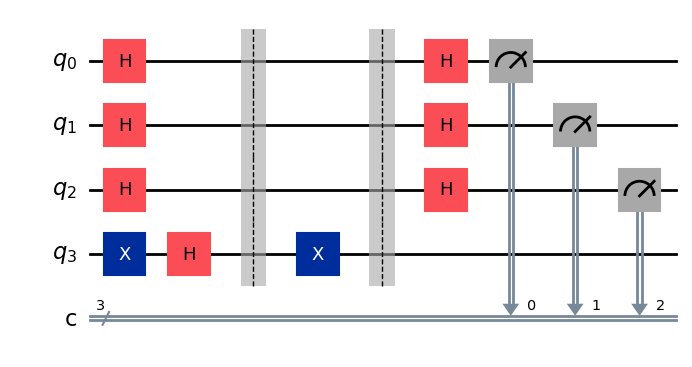

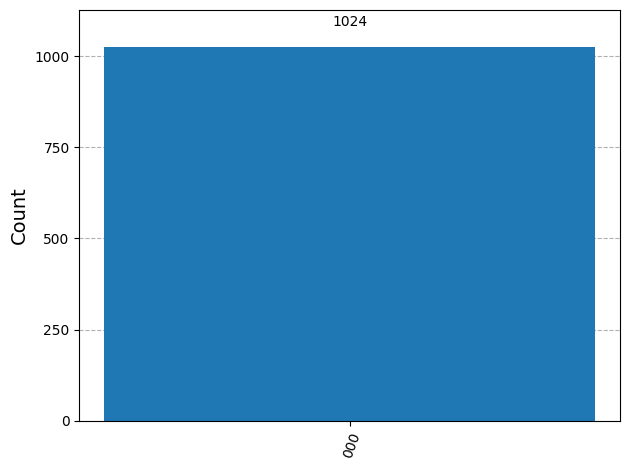

Results for n=3 parity3:
{'111': 1024}


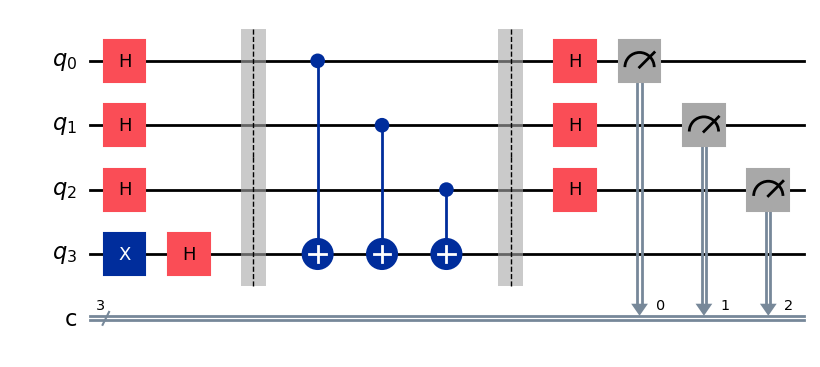

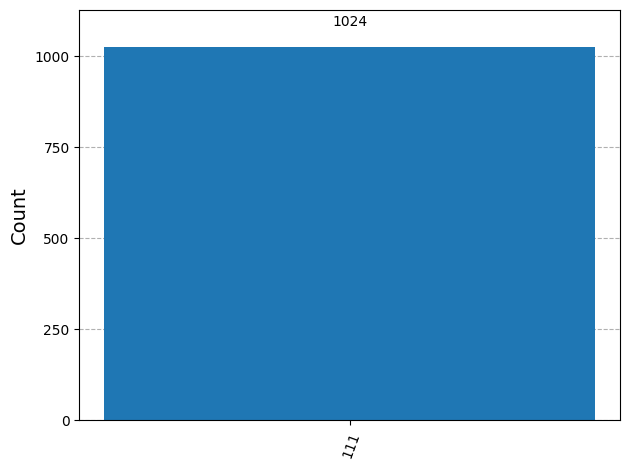

Results for n=3 proj_q1:
{'010': 1024}


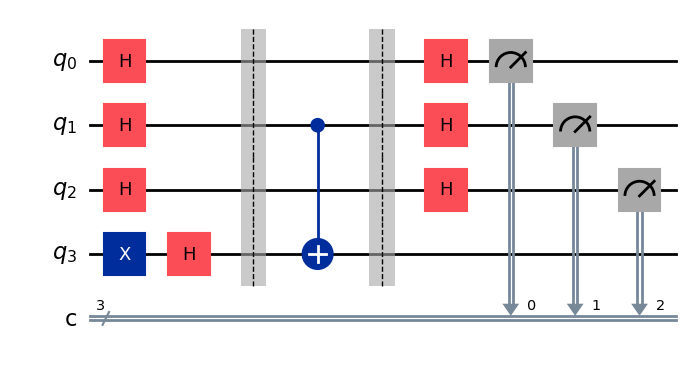

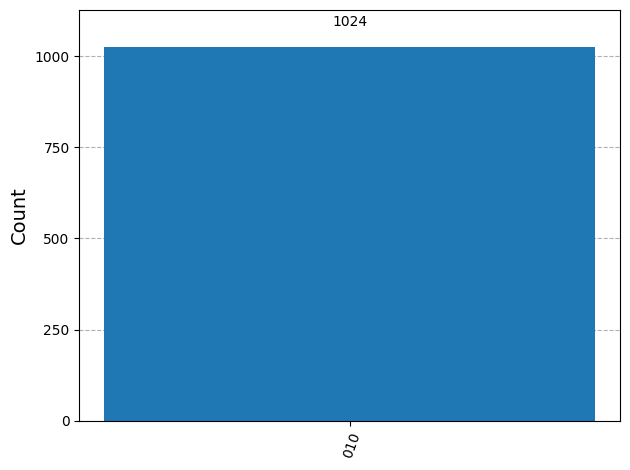

In [41]:
def run_and_plot(oracle, n, title=''):
    dj_qc = deutsch_jozsa_circuit(oracle, n)
    # transpile / convert to qasm for simulator
    sim = AerSimulator()
    # execute
    job = sim.run([dj_qc], shots=1024)
    result = job.result()
    counts = result.get_counts()
    print(f"Results for {title}:")
    print(counts)
    display(dj_qc.draw('mpl'))
    display(plot_histogram(counts))
    return counts

# Example runs:
for name, oracle in oracles_n1.items():
    run_and_plot(oracle, 1, title=f'n=1 {name}')

for name, oracle in oracles_n2.items():
    run_and_plot(oracle, 2, title=f'n=2 {name}')

for name, oracle in oracles_n3.items():
    run_and_plot(oracle, 3, title=f'n=3 {name}')
